In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

# Observation Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def model_info(source, filt, dist):
    
    base_dir  = '/Volumes/NIRData/Andras_models_v2/'
    model_dir = base_dir + source + '/'
    
    # Match filters with model
    filt_switch = {'F182M':'F210M', 'F210M':'F210M', 'F250M':'F250M',
                   'F300M':'F300M', 'F335M':'F335M', 'F444W':'F444W'}
    filt_model = filt_switch.get(filt, filt)
    fname = source + '_' + filt_model +'sc.fits'

    bp = nrc_utils.read_filter(filt_model)
    w0 = bp.avgwave() / 1e4

    # Model pixels are 4x oversampled
    detscale = (nrc_utils.channel_select(bp))[0]
    model_scale = detscale / 4.
    
    # File name, arcsec/pix, dist (pc), wavelength (um), flux units
    args_model = (model_dir+fname, model_scale, dist, w0, 'Jy/pixel')

    return args_model

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, disk_mod=True, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    fov_pix_orig = fov_pix

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if disk_mod:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)
        
        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        fov_pix = subsize = 320 if fov_pix is None else fov_pix
        oversample = 2

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, 
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

In [6]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, tacq_max=1800, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = obs_dict.keys()
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)
        
        # SW filter piggy-back on two LW filters, so 2 x tacq
        is_SW = obs.bandpass.avgwave()/1e4 < 2.5

        sci = obs
        ref = sci.nrc_ref

        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, tacq_max=tacq_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)

            # SW filter piggy-back on two LW filters, so 2 x tacq
            is_SW = obs.bandpass.avgwave()/1e4 < 2.5
            if is_SW: v3 *= 2
            
            # Coronagraphic observations have two roll positions, so cut NINT by 2
            if obs.mask is not None: v3 = int(v3/2) 
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Plotting contrasts and planet magnitudes

Functions to plot simulated images and contrast curves

In [7]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    import matplotlib.patches as patches
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    dist = obs.distance
    
    pmag = planet_mags(obs, age, entropy, mass_list, av_vals)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {:.0f} Myr; '.format(age)
    dist_str = 'Dist = {:.1f} pc; '.format(dist) if dist is not None else ''
    #dist_str=""

    ax.set_title('{} -- {} ({}{}{})'.format(obs.filter,ent_str,age_str,dist_str,av_str))


In [8]:
from copy import deepcopy

def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(14,7.5))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        mask_good = data_mod>(0.1*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        
        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.1*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: ax.set_title(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            
    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    texp = round(2*texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Functions to init, optimize, and plot

In [9]:
# Generate initial observations for each filter(no WFE drift)
def do_init(disk_mod=True, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       disk_mod=disk_mod, verbose=verbose)
    return obs_dict

In [10]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [11]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [12]:
def do_plot_contrast(curves, wfe_list, nsig, age, dist, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs_dict[key], age=age, entropy=entropy_vals[j], dist=dist)

    import matplotlib.patches as mpatches
    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim([0,10])
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)
        
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [13]:
def do_gen_hdus(obs_dict, wfe_drift, **kwargs):
    
    hdulist_dict = {}
    for key in filt_keys:
        obs = obs_dict[key]
        obs.wfe_drift = wfe_drift
        hdulist = obs.gen_roll_image(PA1=0, PA2=10, **kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

## Define Source and their Reference Counterparts

In [85]:
#                source,    dist,  fov, age,  sptype, kmag
args_sources = [('HD10647',  17.43, 14, 1000, 'F9V', 4.3),
                ('HD107146', 27.50, 14,  150, 'G2V', 5.5),
                ('HD181327', 51.80,  7,   12, 'F6V', 5.9),
                ('HD61005',  34.50,  7,  100, 'G8V', 6.5),
                ('HD32297',  113.0,  7,   30, 'A0V', 7.6)]

ref_sources  = [('iotHor',   'F8V',  4.1),
                ('HD111398', 'G5V',  5.5),
                ('HR7297',   'F7V',  5.1),
                ('HD56161',  'G5IV', 4.9),
                ('HD31411',  'A0V',  6.4)]

In [55]:
# List of filters
args_list = [('F182M', 'MASK335R', 'CIRCLYOT'),
             ('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F250M', 'MASK335R', 'CIRCLYOT'),
             ('F300M', 'MASK335R', 'CIRCLYOT'),
             ('F335M', 'MASK335R', 'CIRCLYOT'),
             ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [56]:
# K-Band Filter
bp_k = S.ObsBandpass('k')

In [57]:
outdir  = '/Volumes/NIRData/Andras_obs_v3/'

## HD 10647

In [58]:
i=0

name_sci, dist_sci, fov, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [59]:
obs_dict = do_init(verbose=False)

In [60]:
obs = obs_dict[filt_keys[0]]

In [61]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]

    ng, nint_sci, nint_ref = (8,23,25)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2

    obs.update_detectors(read_mode='MEDIUM8', ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=ng, nint=nint_ref)

In [62]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift)

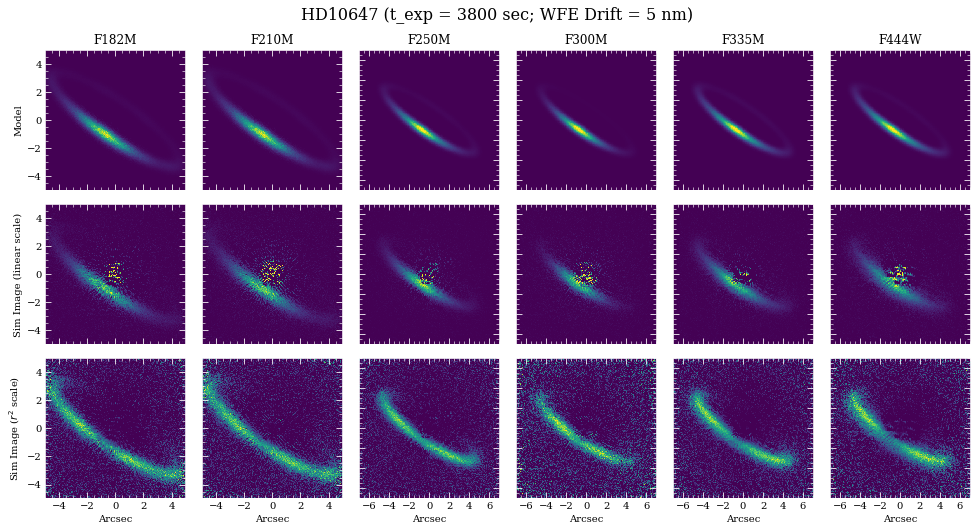

In [63]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=True)

In [24]:
# List of WFE drifts to check
wfe_list = [0,1,2,5,10][::-1]
nsig = 5
# Get contrasts for each WFE drift
F444W_key = [key for key in filt_keys if "F444W" in key]
contrast_F444W = do_contrast(wfe_list, F444W_key, nsig=nsig)

F444W_MASK335R_CIRCLYOT


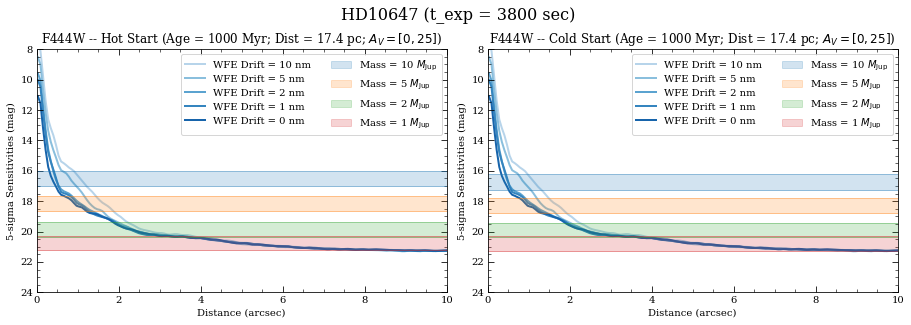

In [25]:
curves = contrast_F444W[F444W_key[0]]
do_plot_contrast(obs, curves, wfe_list, nsig, age, save_fig=True)

## HD 107146

In [64]:
i=1

name_sci, dist_sci, fov, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [65]:
obs_dict = do_init(verbose=False)

In [66]:
# Optimize readout parameters
tacq = 3800
#do_opt(tacq, patterns='MEDIUM8', ng_min=10, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]
    obs.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=18)
    obs.nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=20)

In [67]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift)

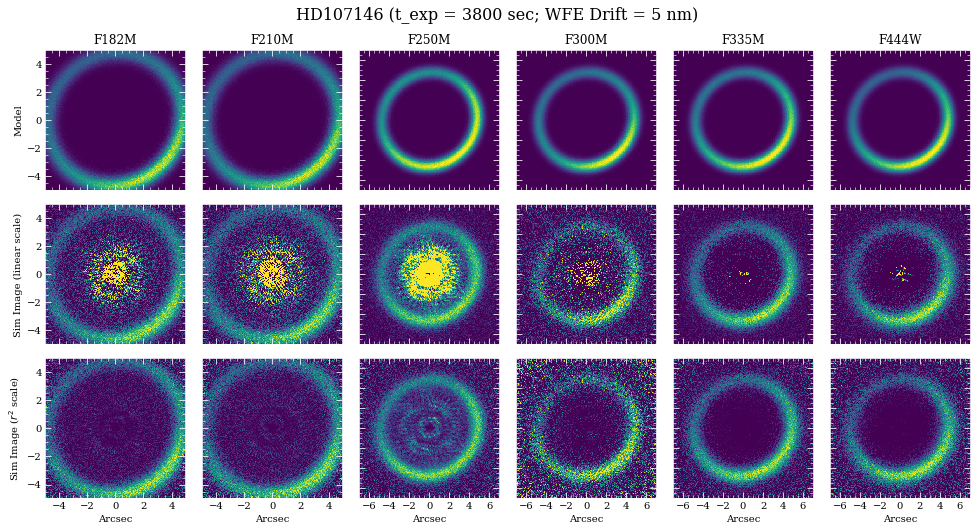

In [68]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=True)

In [31]:
# List of WFE drifts to check
wfe_list = [0,1,2,5,10][::-1]
#wfe_list = [0,10][::-1]
nsig = 5
# Get contrasts for each WFE drift
F444W_key = [key for key in filt_keys if "F444W" in key]
contrast_F444W = do_contrast(wfe_list, F444W_key, nsig=nsig)

F444W_MASK335R_CIRCLYOT


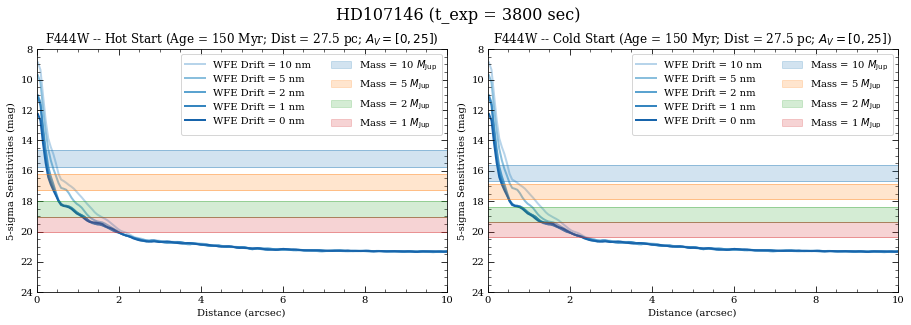

In [32]:
curves = contrast_F444W[F444W_key[0]]
do_plot_contrast(obs, curves, wfe_list, nsig, age, save_fig=True)

## HD 181327

In [70]:
i=2

name_sci, dist_sci, fov, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [71]:
obs_dict = do_init(verbose=False)

In [72]:
# Optimize readout parameters
tacq = 3000
#do_opt(tacq, patterns='MEDIUM8', ng_min=10, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]
    obs.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=12)
    obs.nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=20)

In [73]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift)

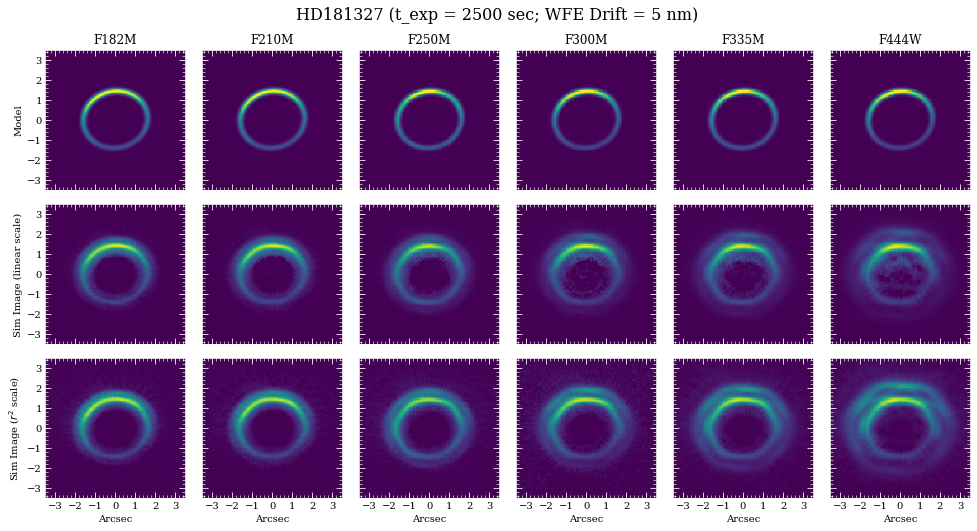

In [74]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=True)

In [38]:
# List of WFE drifts to check
wfe_list = [0,1,2,5,10][::-1]
nsig = 5
# Get contrasts for each WFE drift
F444W_key = [key for key in filt_keys if "F444W" in key]
contrast_F444W = do_contrast(wfe_list, F444W_key, nsig=nsig)

F444W_MASK335R_CIRCLYOT


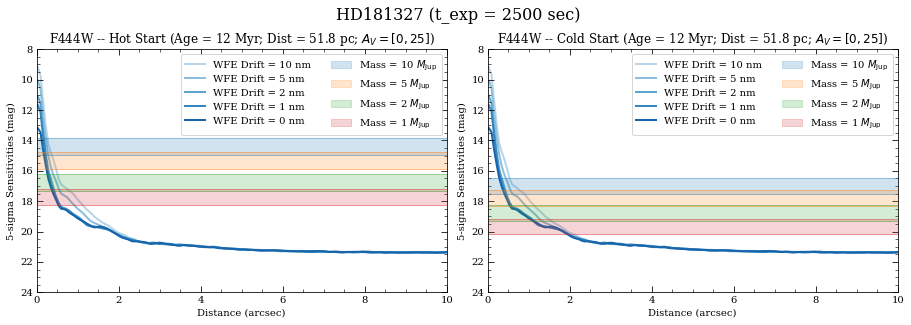

In [39]:
curves = contrast_F444W[F444W_key[0]]
do_plot_contrast(obs, curves, wfe_list, nsig, age, save_fig=True)

## HD 61005

In [75]:
i=3

name_sci, dist_sci, fov, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [76]:
obs_dict = do_init(verbose=False)

In [77]:
# Optimize readout parameters
tacq = 3000
#do_opt(tacq, patterns='MEDIUM8', ng_min=10, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]
    obs.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=12)
    obs.nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=20)

In [78]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift)

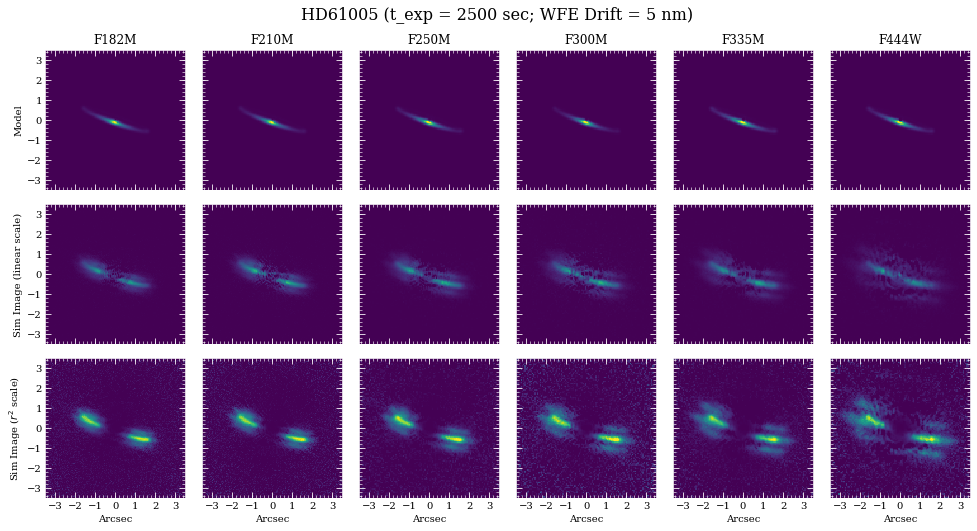

In [79]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=True)

In [45]:
# List of WFE drifts to check
wfe_list = [0,1,2,5,10][::-1]
nsig = 5
# Get contrasts for each WFE drift
F444W_key = [key for key in filt_keys if "F444W" in key]
contrast_F444W = do_contrast(wfe_list, F444W_key, nsig=nsig)

F444W_MASK335R_CIRCLYOT


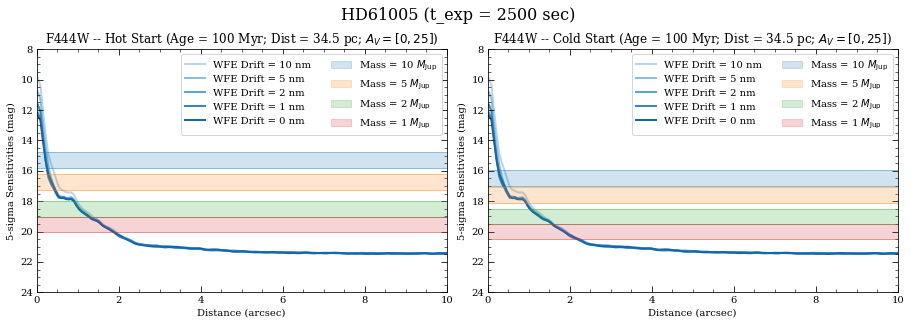

In [46]:
curves = contrast_F444W[F444W_key[0]]
do_plot_contrast(obs, curves, wfe_list, nsig, age, save_fig=True)

## HD 32297

In [86]:
i=4

name_sci, dist_sci, fov, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [81]:
obs_dict = do_init(verbose=False)

In [82]:
# Optimize readout parameters
tacq = 3600
#do_opt(tacq, patterns='MEDIUM8', ng_min=10, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]
    obs.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=16)
    obs.nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=20)

In [83]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift)

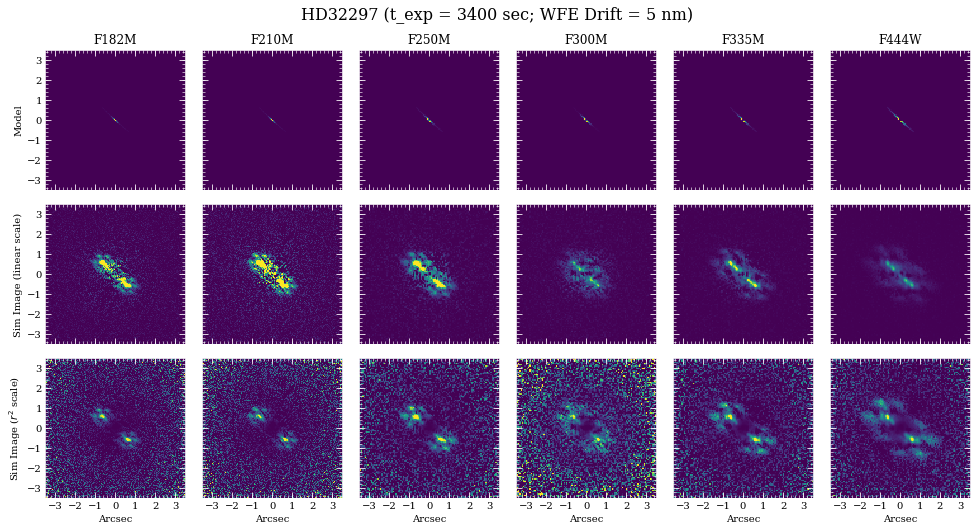

In [87]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=True)

In [52]:
# List of WFE drifts to check
wfe_list = [0,1,2,5,10][::-1]
nsig = 5
# Get contrasts for each WFE drift
F444W_key = [key for key in filt_keys if "F444W" in key]
contrast_F444W = do_contrast(wfe_list, F444W_key, nsig=nsig)

F444W_MASK335R_CIRCLYOT


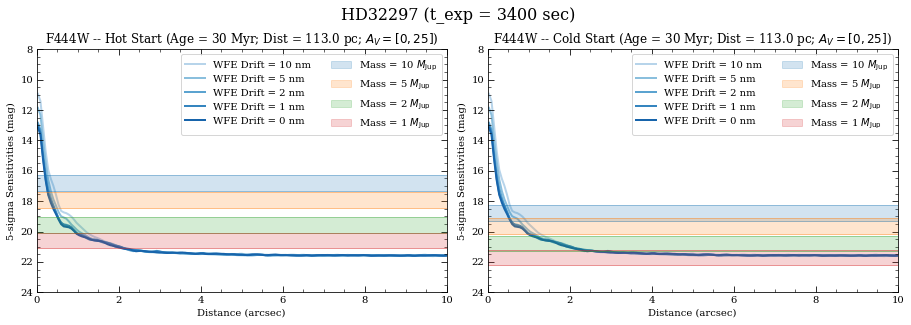

In [53]:
curves = contrast_F444W[F444W_key[0]]
do_plot_contrast(obs, curves, wfe_list, nsig, age, save_fig=True)